# Assignment 4
## Training a DNN for relation classification

In this assignment you are required to build a full training and testing pipeline for a neural relation classification (RC), using BERT.


**In this work we will use the hugingface framework for transformers training and inference.**
We recomand reading the documentation in [this](https://huggingface.co/docs/transformers/main/en/model_doc/bert#transformers.BertForSequenceClassification) link *before* you start coding.


All additional packages:

In [2]:
# !pip install --q
!pip install --q transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.2/7.2 MB 51.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.8/236.8 kB 20.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 46.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 38.2 MB/s eta 0:00:00


All imports: (You may add/change)

In [14]:
# general
import re
import warnings
from typing import List,Tuple

# ML
import numpy as np
import pandas as pd
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix, precision_recall_fscore_support, classification_report

# visual
import matplotlib
import seaborn as sns
from tqdm import tqdm
from tabulate import tabulate
import matplotlib.pyplot as plt
from IPython.display import display

# DL
import torch
from torch import nn, optim, Tensor
from torch.utils.data import DataLoader, Dataset

# HF
from transformers import BertTokenizer
from transformers import BertForSequenceClassification

Set warnings filter to ignore:

In [ ]:
# TO DO
warnings.warn('ignore')

<ipython-input-131-a4f58c1b57b3>:2: UserWarning: ignore
  warnings.warn('ignore')


Set random SEEDs:

In [ ]:
# TO DO

Set GPU:

In [ ]:
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
# assert DEVICE == 'cuda'

## Global params

In [24]:
STUDENT_1_ID = '1'
STUDENT_2_ID = '2'

## Dataset


The dataset that you will be working on is called SemEval Task 8 dataset (https://arxiv.org/pdf/1911.10422v1.pdf).
The dataset contain only train and test split, but you are allowed to split the train dataset into dev if needed.


The two files (train and test) are available from the course git repository (https://github.com/kfirbar/nlp-course)

> Train file: `nlp-course/TRAIN_FILE.TXT`
> Test file: `nlp-course/TEST_FILE_FULL.TXT`


In [ ]:
!git clone https://github.com/kfirbar/nlp-course ../nlp-course

fatal: destination path '../nlp-course' already exists and is not an empty directory.


## Task #1

Write a funtion `read_data` for reading the data from a single file (either train or test).

<br>

This function recieves a filepath and returns a list of sentences; Every sentence is encoded as a tuple.

The first element is the sentence string.
The second element is the label (also represented as a sting).

In [ ]:
def read_data(filepath:str) -> List[Tuple[str,str]]:
    sentences = []
    sample = []

    with open(filepath, 'r') as file:
        for line in file.readlines():
            line = line.strip()
            if line == '':
                continue

            if line.startswith('Comment:'):
                # sentences.append(tuple(*sample))
                sentences.append((sample[0], sample[1]))
                sample = []
                continue

            sample.append(line)

    return [(sent.split('"')[1], label) for sent, label in sentences]
# To DO
train = read_data('../nlp-course/TRAIN_FILE.TXT')
test = read_data('../nlp-course/TEST_FILE_FULL.TXT')

print('Number of train sentences:', len(train))
print('Number of test sentences:', len(test))

Number of train sentences: 8000
Number of test sentences: 2717


In [ ]:
train[:3]

[('The system as described above has its greatest application in an arrayed <e1>configuration</e1> of antenna <e2>elements</e2>.',
  'Component-Whole(e2,e1)'),
 ('The <e1>child</e1> was carefully wrapped and bound into the <e2>cradle</e2> by means of a cord.',
  'Other'),
 ('The <e1>author</e1> of a keygen uses a <e2>disassembler</e2> to look at the raw assembly code.',
  'Instrument-Agency(e2,e1)')]

`Pytorch` require the labels to be integers.

Create a mapper (dictionary) from the string labels to integers (starting zero).
And a dictionary from label to integer.

In [ ]:
def create_label_mapper(data: List[Tuple[str,str]]):
  labels = [label for _, label in data]
  return {i: label for i, label in enumerate(set(labels))}

id2label = create_label_mapper(train)
label2id = {label: i for i, label in id2label.items()}

assert len(id2label) == len(label2id)
print('id2label: \n',id2label)

id2label: 
 {0: 'Content-Container(e2,e1)', 1: 'Component-Whole(e2,e1)', 2: 'Message-Topic(e1,e2)', 3: 'Member-Collection(e2,e1)', 4: 'Entity-Destination(e2,e1)', 5: 'Instrument-Agency(e1,e2)', 6: 'Product-Producer(e1,e2)', 7: 'Other', 8: 'Component-Whole(e1,e2)', 9: 'Instrument-Agency(e2,e1)', 10: 'Cause-Effect(e1,e2)', 11: 'Message-Topic(e2,e1)', 12: 'Entity-Destination(e1,e2)', 13: 'Product-Producer(e2,e1)', 14: 'Member-Collection(e1,e2)', 15: 'Entity-Origin(e1,e2)', 16: 'Content-Container(e1,e2)', 17: 'Cause-Effect(e2,e1)', 18: 'Entity-Origin(e2,e1)'}


<br>

Plot the distribution of labels in each dataset.
Display the information in a single plot.

For example:

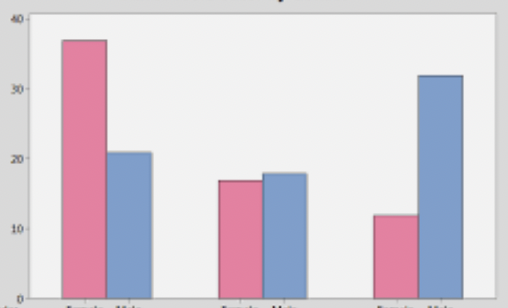

- Use bar plot.
- Use figuresize of (16,6).
- Add titles and Axis names.
- Y-axis will hold the count for each label.
- X-axis will hold the name of each label.

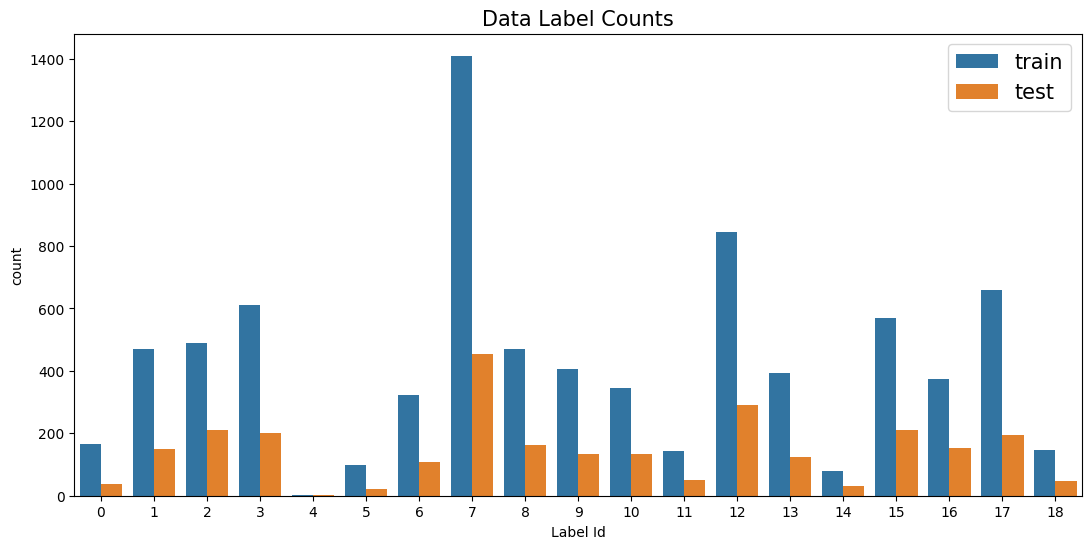

In [ ]:
plt.figure(figsize=(13,6))
train_labels = [label2id[l] for _,l in train]
test_labels = [label2id[l] for _,l in test]
sns.countplot(x=train_labels + test_labels, hue=['train'] * len(train_labels) + ['test'] * len(test_labels))
plt.title('Data Label Counts', size=15)
plt.xlabel('Label Id')
plt.legend(prop={'size': 15})

<br>

<br><br><br><br>


## Task #2

Download the relevant BERT tokenizer.
Use `bert-base-uncased` .


In [ ]:
# TO DO
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

Write a function `prepare_data` that takes one of the `train & test` datasets and convert each pair of `(words,labels)` to a pair of indexes.

The function also aggregate the samples into batches.

BERT Uses pretrained tokanization and embedding.
you can access the tokanization and indexing using the `BertTokenizer` class.

Note: you may use `torch.utils.data.Dataset`

In [ ]:
class RCDataset(Dataset):
    def __init__(self, data, tokenizer: BertTokenizer):
        self.data = data
        self.tokenizer = tokenizer

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        words, label = self.data[index]
        label = torch.tensor(label2id[label]).to(DEVICE)
        encoded_inputs = self.tokenizer.encode_plus(
            words,
            add_special_tokens=True,
            padding='max_length',
            truncation=True,
            max_length=128,
            return_tensors='pt',
        ).to(DEVICE)
        input_ids = encoded_inputs['input_ids'].squeeze().to(DEVICE)
        attention_mask = encoded_inputs['attention_mask'].squeeze().to(DEVICE)

        return input_ids, attention_mask, label

In [ ]:
def prepare_data(data: List[Tuple[str,str]], tokenizer: BertTokenizer, batch_size=8) -> DataLoader:
    dataset = RCDataset(data, tokenizer)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

    return dataloader


train_sequences = prepare_data(train, tokenizer)
test_sequences = prepare_data(test, tokenizer)

In [ ]:
next(iter(train_sequences))

[tensor([[  101, 17805,  1005,  ...,     0,     0,     0],
         [  101,  1996,  1026,  ...,     0,     0,     0],
         [  101,  1996,  1026,  ...,     0,     0,     0],
         ...,
         [  101,  2613,  1026,  ...,     0,     0,     0],
         [  101,  1996,  8112,  ...,     0,     0,     0],
         [  101,  1026,  1041,  ...,     0,     0,     0]], device='cuda:0'),
 tensor([[1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0],
         ...,
         [1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0]], device='cuda:0'),
 tensor([ 9, 10,  1,  9,  3,  9, 10, 18], device='cuda:0')]

<br><br><br><br>

## Task #3

In this part we classify the sentences using the `BertForSequenceClassification` model.


Download the relevant BERT model. Use `bert-base-uncased` .

In [ ]:
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=len(label2id)).to(DEVICE)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly i

In [ ]:
input_ids, attention_mask, labels = next(iter(train_sequences))
model.forward(input_ids, attention_mask, labels=labels)['logits']

tensor([[-0.3757,  0.5441,  0.0799,  0.3334,  0.0345,  0.2318,  0.6247, -0.6829,
          0.0827,  0.0441, -0.1044,  0.0614, -0.6324, -0.0780,  0.0612, -0.1612,
          0.7522,  0.5086, -0.3285],
        [-0.4953,  0.4390, -0.1140,  0.3820,  0.0260,  0.0544,  0.5482, -0.4997,
          0.0476,  0.0016, -0.0612, -0.0678, -0.6938, -0.1669,  0.2175,  0.0359,
          0.7032,  0.4486, -0.3443],
        [-0.3057,  0.5185, -0.0985,  0.2793, -0.0375,  0.1281,  0.4671, -0.3977,
          0.3204,  0.0463, -0.1198, -0.0805, -0.6277, -0.2815,  0.2430, -0.0064,
          0.6929,  0.4597, -0.1601],
        [-0.3770,  0.5771, -0.0295,  0.3721,  0.1044,  0.1473,  0.5535, -0.5914,
         -0.0079,  0.1256, -0.0050, -0.0596, -0.7412, -0.0268,  0.2004,  0.0627,
          0.7750,  0.6051, -0.3039],
        [-0.2776,  0.4564,  0.0043,  0.2856,  0.0478,  0.2079,  0.5772, -0.6234,
          0.0781,  0.0337, -0.1186,  0.0057, -0.6538, -0.0290,  0.1559, -0.0949,
          0.7192,  0.5123, -0.3025],
     


Write a function `get_parameters` that gets the model as an input and return the top(final) layer of the model for a `torch` optimizer.

Note: take a look at these links [link1](https://jimmy-shen.medium.com/pytorch-freeze-part-of-the-layers-4554105e03a6#:~:text=%3E%3E%3E-,for%20name%2C%20para%20in%20net.named_parameters()%3A,-...%20%20%20%20%20para.requires_grad%20%3D%20False) [link2](https://pytorch.org/docs/stable/generated/torch.Tensor.requires_grad_.html) .


In [ ]:
def get_final_layer_idx(model: BertForSequenceClassification):
  final_layer = 0
  named_params = [*model.named_parameters()]
  for name, _ in named_params[::-1]:
    existing_numbers = re.findall(r'\d+', name)
    if len(existing_numbers) > 0:
      final_layer =  existing_numbers[0]
      break

  for i, (name, _) in enumerate(named_params):
    if final_layer in name.split('.'):
      return i


def get_parameters(model: BertForSequenceClassification):
  params_to_train = []
  final_layer_idx = get_final_layer_idx(model)
  for i, (_, param) in enumerate(model.named_parameters()):
    if i >= final_layer_idx:
      params_to_train.append(param)
    else:
      param.requires_grad = False

  return params_to_train

top_layer_params = get_parameters(model)

Define the optimizer:

- Use the `ADAM` optimizer (from `torch.optim`), which is a fancy version of SGD.
- Use a learning rate of 0.0001.
- Send only the top/final layer of the model to the optimizer (use `top_layer_params`).


In [ ]:
# TO DO
optimizer = optim.Adam(top_layer_params, lr=1e-4)
criterion = nn.CrossEntropyLoss().to(DEVICE)

<br><br><br><br>

## Task #4

Let's create the trainig function!


1. Write a training function, which takes a the model `BertForSequenceClassification` and number of epochs to train on.

2. Set `criterion` to the `CrossEntropyLoss` (from `torch.nn`) and use the `ADAM` optimizer.

3. Use a simple `for` loop to iterate over the epochs.
Use [tqdm](https://github.com/tqdm/tqdm) to mark your iteration and progress.

Notes:
- You may to split the `train` to `train&dev` sets.
- You may change the input/output of the training function.


In [ ]:
def training(model: BertForSequenceClassification, n_epochs: int, train_data: RCDataset, optimizer: optim.Optimizer, criterion: nn.CrossEntropyLoss):
  losses = []
  for epoch_i in range(n_epochs):
    with tqdm(total=len(train_data), desc=f"Epoch {epoch_i + 1}", unit="batch") as progress_bar:
      epoch_losses = []
      for input_ids, attention_mask, labels in train_data:
        optimizer.zero_grad()
        output = model.forward(input_ids, attention_mask, labels=labels)
        loss: Tensor = criterion(output['logits'], labels)
        loss.backward()
        epoch_losses.append(loss.item())
        optimizer.step()

        progress_bar.set_postfix({"Loss": loss.item()})
        progress_bar.update()
      losses.append(np.mean(epoch_losses))

  return losses

In [ ]:
training(model, 5, train_sequences, optimizer, criterion)

Epoch 5: 100%|██████████| 1000/1000 [01:13<00:00, 13.70batch/s, Loss=0.0123]


[1.4007707154005766,
 0.642293930888176,
 0.3427634542910382,
 0.1454765409284737,
 0.08622083361417754]

In [ ]:
trues = 0
with torch.no_grad():
  for input_ids, attention_mask, labels in train_sequences:
    output = model.forward(input_ids, attention_mask, labels=labels)
    preds = output.logits.argmax(1)
    trues += (preds == labels).sum()

trues / len(train_sequences.dataset)

tensor(0.9789, device='cuda:0')

In [ ]:
trues = 0
with torch.no_grad():
  for input_ids, attention_mask, labels in test_sequences:
    output = model.forward(input_ids, attention_mask, labels=labels)
    preds = output.logits.argmax(1)
    trues += (preds == labels).sum()

trues / len(test_sequences.dataset)

tensor(0.7446, device='cuda:0')

<br><br><br><br>

## Task #5

Write an evaluation loop on a trained model, using the test dataset.

Instructions:
> Input: model, data
> Output: Report, Confusion matrix

> 1. Display: Report, Confusion matrix
> 2. Save: a csv report


Explanation:
This function will perform an evaluation over a model with a dataset.
Calculate the `PERCISION, RECALL, F1` scores of each label seperately, and display them in a table.

Display a confusion matrix plot: where the predicted labels are the rows, and the true labels are the columns.


In addition, load thwe report to a dataframe and save to a CSV with this name:

> `{student_id_1}_{student_id_n}_part5.csv`
For example: `300123123_200456789_part_5.csv`



In [ ]:
cols   = ['PERCISION','RECALL','F1']
reduced_label_cols = ['Other', 'Cause-Effect', 'Component-Whole', 'Content-Container', 'Entity-Destination', 'Entity-Origin', 'Instrument-Agency', 'Member-Collection', 'Message-Topic', 'Product-Producer']
reduced_labels = {}
for label in label2id.keys():
    for i, reduced_label in enumerate(reduced_label_cols):
        if reduced_label in label:
            reduced_labels[label2id[label]] = i

In [ ]:
def evaluate(model: BertForSequenceClassification, test_data: DataLoader, matrix=False, verbose=False):
  with torch.no_grad():
    model.eval()
    total_labels = torch.empty(0, dtype=int)
    total_preds = torch.empty(0, dtype=int)
    for input_ids, attention_mask, labels in test_data:
      labels_reduced = labels.cpu().apply_(lambda t: reduced_labels[t])
      total_labels = torch.cat([total_labels, labels_reduced.flatten()])
      output = model.forward(input_ids, attention_mask, labels=labels)
      preds = torch.argmax(output.logits, 1)
      preds_reduced = preds.cpu().apply_(lambda t: reduced_labels[t])
      total_preds = torch.cat([total_preds, preds_reduced])
  precision, recall, f1_score, _  = precision_recall_fscore_support(total_labels.cpu().numpy(), total_preds.cpu().numpy())
  metrics = [recall, precision, f1_score]
  if verbose:
    df = pd.DataFrame({col: data for col, data in zip(cols, metrics)}, columns=cols)
    df.index = reduced_label_cols
    print(tabulate(df, headers='keys', tablefmt='psql'))
  if matrix:
    fig, ax = plt.subplots(1,1, figsize=(11,6))
    cm = confusion_matrix(total_labels.cpu().numpy(), total_preds.cpu().numpy(), labels=total_labels.unique().cpu().numpy())
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=reduced_label_cols)
    disp.plot(ax=ax, colorbar=False)
    disp.ax_.set_title('Confusion Matrix', size=17)
    disp.ax_.set_xticks([])
    fig.tight_layout()
  return metrics

+--------------------+-------------+----------+----------+
|                    |   PERCISION |   RECALL |       F1 |
|--------------------+-------------+----------+----------|
| Other              |    0.539648 | 0.51797  | 0.528587 |
| Cause-Effect       |    0.905488 | 0.855908 | 0.88     |
| Component-Whole    |    0.727564 | 0.869732 | 0.792321 |
| Content-Container  |    0.901042 | 0.755459 | 0.821853 |
| Entity-Destination |    0.924658 | 0.841121 | 0.880914 |
| Entity-Origin      |    0.689922 | 0.859903 | 0.765591 |
| Instrument-Agency  |    0.724359 | 0.668639 | 0.695385 |
| Member-Collection  |    0.781116 | 0.758333 | 0.769556 |
| Message-Topic      |    0.842912 | 0.842912 | 0.842912 |
| Product-Producer   |    0.718615 | 0.794258 | 0.754545 |
+--------------------+-------------+----------+----------+


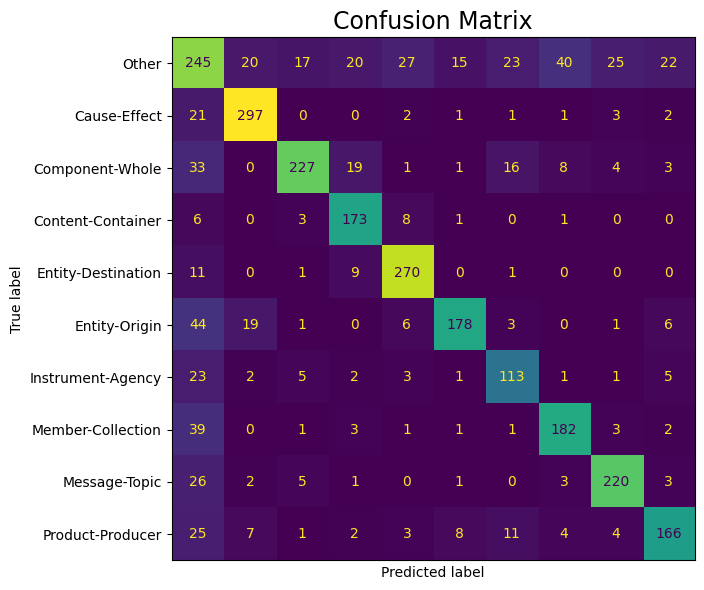

In [ ]:
data = evaluate(model, test_sequences, matrix=True, verbose=True)

In [ ]:
# Example:
# results_acc = np.random.rand(10, 4)
# df = pd.DataFrame(results_acc,columns=cols)
# df.index = labels
# print(tabulate(df, headers='keys', tablefmt='psql',floatfmt=".4f"))

+--------------------+-------------+----------+--------+-----------+
|                    |   PERCISION |   RECALL |     F1 |   SUPPORT |
|--------------------+-------------+----------+--------+-----------|
| Other              |      0.1892 |   0.2476 | 0.9434 |    0.6798 |
| Cause-Effect       |      0.3733 |   0.7250 | 0.8097 |    0.3035 |
| Component-Whole    |      0.1473 |   0.3363 | 0.4331 |    0.6461 |
| Content-Container  |      0.2430 |   0.4153 | 0.6325 |    0.4271 |
| Entity-Destination |      0.6642 |   0.7905 | 0.2865 |    0.7330 |
| Entity-Origin      |      0.8269 |   0.3529 | 0.9726 |    0.8400 |
| Instrument-Agency  |      0.1594 |   0.0091 | 0.1491 |    0.9549 |
| Member-Collection  |      0.4040 |   0.0345 | 0.6856 |    0.1692 |
| Message-Topic      |      0.1546 |   0.0200 | 0.9448 |    0.8326 |
| Product-Producer   |      0.7252 |   0.1796 | 0.6077 |    0.3675 |
+--------------------+-------------+----------+--------+-----------+


<br><br><br><br>

## Task #6

In this part we'll improve the model accuracy by using a method called "entity markers - Entity start".

The main idea of this approch is to add special markers ([e1], [\e1], ...) before and after each of the tagged entities. Instead of using the `CLS token` for clasification, we will use the concatination of the embedding of `[e1]` and `[e2]` as shown in the image below.

The complete method is described in details in the paper [Matching the Blanks: Distributional Similarity for Relation Learning following](https://arxiv.org/pdf/1906.03158.pdf) (specifically in Section 3.2).

 To use this method we'll need to create a new data load and a new model.

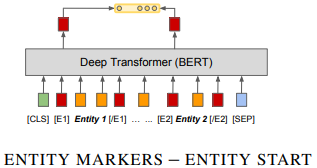

The new methods require the usage of special tokens.
Fix the following code so it will add the required tokens:

In [ ]:
E1_START = '<e1>'
E1_END   = '</e1>'
E2_START = '<e2>'
E2_END   = '</e2>'

# TO DO
new_tokens = []
mtb_tokenizer = None
mtb_tokenizer.add_tokens(new_tokens)

Create a new dataloader that add entity markers to the dataset and return their indexes as part of the new sample (the expected sample should be (s, l, i) where s is the sentence embedding, l is the label, and i is a touple with the indexes of the start entities)

Note: you may change the classes, function, etc.

In [ ]:
# TO DO
class MTBRCDataset(torch.utils.data.Dataset):
  def __init__(self):
    super(MTBRCDataset, self).__init__()


In [ ]:
# TO DO

def prepare_data_MTB(data, tokenizer, batch_size=8):
    data_sequences = []
    # TO DO

    return data_sequences

# Example
# train_sequences = prepare_data_MTB(train, tokenizer)
# test_sequences = prepare_data_MTB(test, tokenizer)

mtb_train_dl = None
mtb_dev_dl = None
mtb_test_dl = None

In [ ]:
print(len(mtb_train_dl),len(mtb_dev_dl),len(mtb_test_dl))

Create a new model that uses the "entity markers - Entity start" method.

In [ ]:
class MTB(nn.Module):

    def __init__(self, base_model_name):
      config = AutoConfig.from_pretrained(name)
      self.model = AutoModel.from_config(config)
      # TO DO

    def forward(self, input, index):
      # TO DO

model = MTB('bert-base-uncased')

Use the new dataloader and model to train the new model as in task 4.



**Evaluation**

Use the new dataloader and model to evaluate the new model as in task 5.
> 1. Display: Report, Confusion matrix
> 2. Save: a csv report

Use this format:
> `{student_id_1}_{student_id_n}_part6.csv`
> For example: `300123123_200456789_part_6.csv`


In [ ]:
# TO DO

training(model, n_epochs, train_data, dev_data)
evaluate(model, test_data)

# display()
# save()

<br><br><br><br><br>

## Task 7

In  this final task we will classify similar sentences (1 - similar, 0 - not similar).
We will use an `off the shelf model` and run inference.

- Get the kaggle dataset and create a inference pipeline for the Sentence similarity. Use an off-the-shelf.

Note: you may add change cells as you pleased.


In [8]:
!pip install sentence_transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.0/86.0 kB 6.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 48.8 MB/s eta 0:00:00
  Created wheel for sentence_transformers: filename=sentence_transformers-2.2.2-py3-none-any.whl size=125926 sha256=9e1631dd27d6ba5208d195d53cdd02919d119c71bf9d55c01f3bcb2ad6bb489e
  Stored in directory: /root/.cache/pip/wheels/62/f2/10/1e606fd5f02395388f74e7462910fe851042f97238cbbd902f
Successfully built sentence_transformers


Optional: Clear GPU space if needed

In [4]:
torch.cuda.empty_cache()

Set all the relavant random seed to 111

In [5]:
torch.manual_seed(111)

Download the `train` dataset from [here](https://github.com/saharmilis/runi-nlp/tree/main/kaggle).

In [9]:
!git clone https://github.com/saharmilis/runi-nlp.git ../runi-nlp
data = pd.read_csv('../runi-nlp/kaggle/nlp_2023_train.csv', index_col=0).dropna()

fatal: destination path '../runi-nlp' already exists and is not an empty directory.


Download the sentence similarty tokenizer & model `all-mpnet-base-v2`.
Here the [link](https://huggingface.co/sentence-transformers/all-mpnet-base-v2) to the model.



In [10]:
from sentence_transformers import SentenceTransformer
model = SentenceTransformer('sentence-transformers/all-mpnet-base-v2')

Run inference on the **first 5K lines** in the train dataset, and save it in a dataframe.

In [11]:
train_data = data[:5000]
s1_train = model.encode(train_data['text1'].to_list())
s2_train = model.encode(train_data['text2'].to_list())

In [21]:
train_similarities = nn.CosineSimilarity(dim=1)(torch.tensor(s1_train), torch.tensor(s2_train))
df_t7 = pd.DataFrame({'LABEL_TRUE': train_data['Similarity'], 'LABEL_PRED': (train_similarities > 0.75).int()})

Print a classification report (use a simple SK-learn classification report)

In [22]:
threshold = 0.75
print(classification_report(train_data['Similarity'] > threshold, train_similarities > threshold))

              precision    recall  f1-score   support

       False       0.92      0.75      0.83      3199
        True       0.66      0.89      0.76      1801

    accuracy                           0.80      5000
   macro avg       0.79      0.82      0.79      5000
weighted avg       0.83      0.80      0.80      5000



Save a CSV file as `{student_id_1}_{student_id_n}_part7.csv` with this format: `ID, LABEL_TRUE, LABEL_PRED`

Notice:
- Do not write the index number to the CSV file.
- Make sure the CSV file will contain only integers.


In [25]:
df_t7.to_csv(f'{STUDENT_1_ID}_{STUDENT_2_ID}_part7.csv', index_label='ID')

<br><br><br><br><br><br>
**Good luck!**